In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("S06-hw-dataset-01.csv")

In [3]:
df.head()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18          12

In [5]:
df.describe()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000


In [6]:
df.isnull().sum()

id               0
num01            0
num02            0
num03            0
num04            0
num05            0
num06            0
num07            0
num08            0
num09            0
num10            0
num11            0
num12            0
num13            0
num14            0
num15            0
num16            0
num17            0
num18            0
num19            0
num20            0
num21            0
num22            0
num23            0
num24            0
cat_contract     0
cat_region       0
cat_payment      0
tenure_months    0
target           0
dtype: int64

In [7]:
df['target'].value_counts(normalize=True)

target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

In [8]:
df.columns


Index(['id', 'num01', 'num02', 'num03', 'num04', 'num05', 'num06', 'num07',
       'num08', 'num09', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15',
       'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23',
       'num24', 'cat_contract', 'cat_region', 'cat_payment', 'tenure_months',
       'target'],
      dtype='str')

In [9]:
y = df['target']
x = df.drop(columns=['id', 'target'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Создаем модель
dummy = DummyClassifier(strategy='most_frequent')

# 2. "Обучаем" (на самом деле он просто запомнит самый частый класс)
dummy.fit(X_train, y_train)

# 3. Делаем предсказание для теста
dummy_preds = dummy.predict(X_test)
# Для ROC-AUC нам понадобятся вероятности
dummy_probs = dummy.predict_proba(X_test)[:, 1]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Создаем конвейер
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()), # Шаг 1: Масштабирование
    ('model', LogisticRegression()) # Шаг 2: Модель
])

# Обучаем сразу весь конвейер
log_reg_pipe.fit(X_train, y_train)

# Делаем предсказания
log_reg_preds = log_reg_pipe.predict(X_test)
log_reg_probs = log_reg_pipe.predict_proba(X_test)[:, 1]

In [13]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_preds), 'F1:', f1_score(y_test, log_reg_preds), 'ROC-AUC:', roc_auc_score(y_test, log_reg_probs))
print("Dummy Classifier Accuracy:", accuracy_score(y_test, dummy_preds), 'F1:', f1_score(y_test, dummy_preds), 'ROC-AUC:', roc_auc_score(y_test, dummy_probs))

Logistic Regression Accuracy: 0.8275 F1: 0.7076271186440678 ROC-AUC: 0.8746905312071505
Dummy Classifier Accuracy: 0.6766666666666666 F1: 0.0 ROC-AUC: 0.5


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 1. Создаем "пустую" модель (фиксруем только random_state)
base_tree = DecisionTreeClassifier(random_state=42)

# 2. Описываем сетку параметров (словарь: имя_параметра: список_значений)
tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 5, 10]
}

# 3. Настраиваем поиск
# scoring='roc_auc' — потому что в задании это приоритетная метрика
# cv=5 — количество частей для кросс-валидации
tree_grid = GridSearchCV(base_tree, tree_params, cv=5, scoring='roc_auc', n_jobs=-1)

# 4. Запускаем поиск (только на TRAIN!)
tree_grid.fit(X_train, y_train)

# 5. Узнаем лучшие параметры
print("Best parameters:", tree_grid.best_params_)
print("Best CV score:", tree_grid.best_score_)


Best parameters: {'max_depth': 10, 'min_samples_leaf': 10}
Best CV score: 0.9075932310125838


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best parameters:", rf_grid.best_params_)
print("Best CV score:", rf_grid.best_score_)




Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Best CV score: 0.9686771317959189


In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier

# 1. Создаем базовую модель
hgb_base = HistGradientBoostingClassifier(random_state=42)

# 2. Определяем параметры для перебора
hgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200],
    'max_depth': [3, 5, 10]
}

# 3. Настраиваем поиск (GridSearchCV)
hgb_grid = GridSearchCV(hgb_base, hgb_params, cv=5, scoring='roc_auc', n_jobs=-1)

# 4. Обучаем на TRAIN
hgb_grid.fit(X_train, y_train)

print("Best parameters:", hgb_grid.best_params_)
print("Best CV score:", hgb_grid.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 10, 'max_iter': 200}
Best CV score: 0.9741160982249445


In [17]:
y_pred_dummy = dummy.predict(X_test)
y_pred_log_reg = log_reg_pipe.predict(X_test)
y_pred_rf = rf_grid.predict(X_test)
y_pred_tree = tree_grid.predict(X_test)
y_pred_hgb = hgb_grid.predict(X_test)

# Предсказания вероятностей для ROC AUC
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]
y_proba_log_reg = log_reg_pipe.predict_proba(X_test)[:, 1]
y_proba_rf = rf_grid.predict_proba(X_test)[:, 1]
y_proba_tree = tree_grid.predict_proba(X_test)[:, 1]
y_proba_hgb = hgb_grid.predict_proba(X_test)[:, 1]

data = {
    'Model': ['Dummy', 'Logistic Regression', 'Random Forest', 'Decision Tree', 'HistGradientBoosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dummy),
        accuracy_score(y_test, y_pred_log_reg),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_hgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_dummy),
        f1_score(y_test, y_pred_log_reg),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_tree),
        f1_score(y_test, y_pred_hgb)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_proba_dummy),
        roc_auc_score(y_test, y_proba_log_reg),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_tree),
        roc_auc_score(y_test, y_proba_hgb)
    ]
}

metrics = pd.DataFrame(data)
print(metrics)

                  Model  Accuracy  F1 Score   ROC AUC
0                 Dummy  0.676667  0.000000  0.500000
1   Logistic Regression  0.827500  0.707627  0.874691
2         Random Forest  0.929167  0.885445  0.967295
3         Decision Tree  0.876667  0.800000  0.906921
4  HistGradientBoosting  0.938750  0.902970  0.973808


In [18]:
from sklearn.inspection import permutation_importance

# Считаем важность на тестовых данных
result = permutation_importance(
    hgb_grid, X_test, y_test, 
    n_repeats=10,      # сколько раз перемешивать каждый признак
    random_state=42, 
    scoring='roc_auc'  # на какую метрику смотрим
)

# Выводим среднюю важность для признаков
feature_importance = pd.Series(result.importances_mean, index=X_test.columns)
print(feature_importance.sort_values(ascending=False).head(10))

num18    0.060110
num19    0.044502
num07    0.031460
num04    0.016736
num01    0.013222
num24    0.012400
num14    0.010369
num20    0.008861
num22    0.007255
num16    0.006391
dtype: float64


In [19]:
import joblib
# Сохраняем лучшую модель из грид-серча
joblib.dump(hgb_grid.best_estimator_, 'artifacts/best_model.joblib')

['artifacts/best_model.joblib']

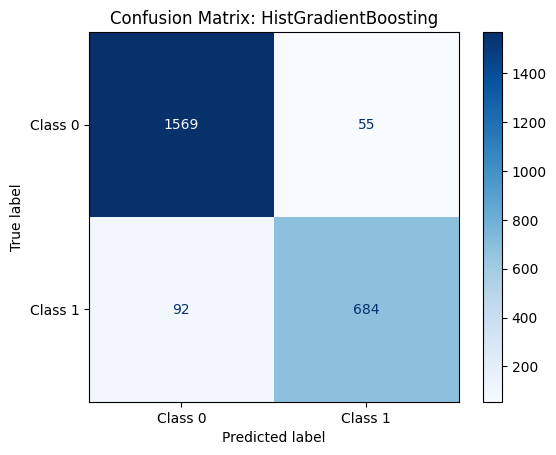

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Создаем объект для отрисовки матрицы ошибок
# Используем лучшую модель из поиска и тестовые данные
disp = ConfusionMatrixDisplay.from_estimator(
    hgb_grid.best_estimator_, 
    X_test, 
    y_test, 
    cmap=plt.cm.Blues,
    display_labels=['Class 0', 'Class 1']
)

# Добавляем заголовок
plt.title("Confusion Matrix: HistGradientBoosting")

# 2. Сохраняем график в папку artifacts/figures/
# Убедись, что папки созданы заранее!
plt.savefig('artifacts/figures/confusion_matrix.png')
plt.show()

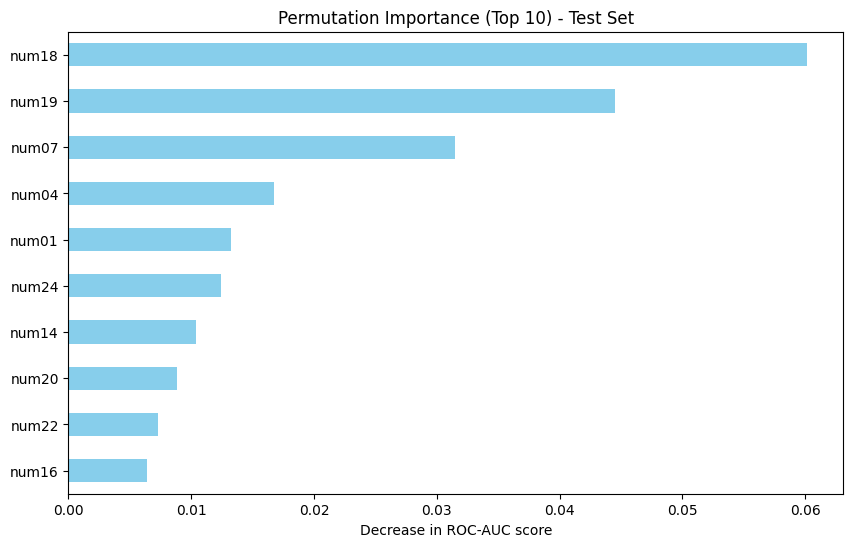

In [21]:
# Строим горизонтальный столбиковый график для Top-10 признаков
plt.figure(figsize=(10, 6))
feature_importance.sort_values().tail(10).plot(kind='barh', color='skyblue')

plt.title("Permutation Importance (Top 10) - Test Set")
plt.xlabel("Decrease in ROC-AUC score")

# Сохраняем второй график
plt.savefig('artifacts/figures/feature_importance.png')
plt.show()

In [22]:

metrics.to_json('artifacts/metrics_test.json', orient='records', indent=4)
print("Метрики сохранены в artifacts/metrics_test.json")


Метрики сохранены в artifacts/metrics_test.json


In [53]:
import joblib

# Сохраняем саму модель
joblib.dump(hgb_grid.best_estimator_, 'artifacts/best_model.joblib')
print("Модель сохранена в artifacts/best_model.joblib")

Модель сохранена в artifacts/best_model.joblib


In [27]:
import json

# Создаем словарь с описанием
meta_data = {
    "model_type": "HistGradientBoostingClassifier",
    "best_params": hgb_grid.best_params_,
    "final_roc_auc_test": roc_auc_score(y_test, y_proba_hgb)
}

# Записываем словарь в файл
with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(meta_data, f, indent=4)
print("Метаданные сохранены в artifacts/best_model_meta.json")

Метаданные сохранены в artifacts/best_model_meta.json


In [24]:
import json

# Создаем словарь с лучшими параметрами для всех моделей
search_summaries = {
    "DecisionTree": {
        "best_params": tree_grid.best_params_,
        "best_cv_score": tree_grid.best_score_
    },
    "RandomForest": {
        "best_params": rf_grid.best_params_,
        "best_cv_score": rf_grid.best_score_
    },
    "HistGradientBoosting": {
        "best_params": hgb_grid.best_params_,
        "best_cv_score": hgb_grid.best_score_
    }
}

# Записываем в файл
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=4)
print("Search summaries сохранены в artifacts/search_summaries.json")

Search summaries сохранены в artifacts/search_summaries.json


<Figure size 800x600 with 0 Axes>

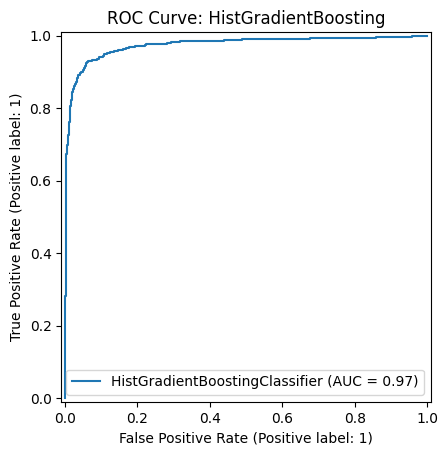

In [25]:
from sklearn.metrics import RocCurveDisplay

# Строим ROC-кривую для лучшей модели
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(hgb_grid.best_estimator_, X_test, y_test)
plt.title("ROC Curve: HistGradientBoosting")
plt.savefig('artifacts/figures/roc_curve.png')
plt.show()

HistGradientBoosting продемонстрировал превосходство в решении задачи бинарной классификации с умеренным дисбалансом классов. Модель достигла F1-Score 0.903 и ROC-AUC 0.974, что свидетельствует о ее высокой эффективности и надежности для практического применения. Анализ важности признаков подтвердил, что модель принимает решения на основе информативных числовых признаков, что повышает доверие к ее предсказаниям.